# 3D (x-y-t) field inference: alpha sensitivity

We start from a flow field generated with `drifter_3D.ipynb` and modify rescale the flow amplitude to change the value of the $\alpha=U\lambda_t/\lambda_s$

In [11]:
import os
from tqdm import tqdm
from itertools import product
import pickle

import numpy as np
import pandas as pd
import xarray as xr
import dask
import dask.array as da
import dask.bag as db

import matplotlib.pyplot as plt
%matplotlib inline

from scipy import stats
import xrft

from gptide import cov
from gptide import GPtideScipy
from gptide import stats as gpstats
from gptide import mcmc
import corner
import arviz as az

import utils as ut
day = 86400

#data_dir = "data/"
#data_dir = "/home1/scratch/aponte/"
data_dir = "/home/datawork-lops-osi/aponte/nwa/drifter_stats"

In [3]:
local_cluster = True
local_cluster = False

if local_cluster:
    from dask.distributed import Client, LocalCluster
    cluster = LocalCluster()
else:
    from dask.distributed import Client, LocalCluster
    from dask_jobqueue import PBSCluster
    cluster = PBSCluster(cores=7*2, processes=7*2, walltime="03:00:00")
    #cluster = PBSCluster(cores=7*2, processes=7*2, walltime="00:30:00")
    # cores=7, processes=7, 02:00:00 by default
    w = cluster.scale(jobs=4)

client = Client(cluster)
client

Connection method: Cluster object,Cluster type: dask_jobqueue.PBSCluster
Dashboard: http://10.148.0.47:8787/status,
Dashboard: http://10.148.0.47:8787/status,Workers: 0
Total threads: 0,Total memory: 0 B
Comm: tcp://10.148.0.47:58277,Workers: 0
Dashboard: http://10.148.0.47:8787/status,Total threads: 0
Started: Just now,Total memory: 0 B


## Prepare distribution of computations

Computations to be distributed:

- Fixed station inference
- Lagrangian simulation and inference


In [12]:
#### 
# start from input file

case = "3D_matern32_iso_matern12_pp_r0.0_u0.2"

uv = True # True if u and v are observed
noise = 0.01 # observation noise added to u/v
no_time = False # activates time inference

# number of points used for inference#
#Nxy, Nt = 1, 50
#Nxy, Nt = 2, 50
Nxy, Nt = 5, 50
#Nxy, Nt = 10, 50
#Nxy, Nt = 1, 50 # dev

# flow scales
#flow_scales = [.2, 1., 5.]
flow_scales = np.arange(.1, 5., .2)

# mcmmc parameters
seed = 0
nwarmup=100
niter=100

---

## prepare inference

In [14]:
# load eulerian flow
flow_file = os.path.join(data_dir, case+"_flow.zarr")
dsf = xr.open_dataset(os.path.join(data_dir, flow_file))
dsf["time"] = dsf["time"]/pd.Timedelta("1D")
U = dsf.attrs["U"] # useful for computation of alpha much latter
dsf.attrs

AttributeError: module 'xarray' has no attribute 'DataArray'

In [ ]:
# problem parameters (need to be consistent with data generation notebook)

p = dsf.attrs
η = p["eta"]  # streamfunction amplitude
#
λx = p["lambda_x"]   # km
λy = p["lambda_y"]   # km
λt = p["lambda_t"]   # days

Lx = float(dsf.x.max()-dsf.x.min())
Ly = float(dsf.y.max()-dsf.y.min())
# km, km this should not matter

In [ ]:
from scipy.special import kv, kvp, gamma

# https://en.wikipedia.org/wiki/Mat%C3%A9rn_covariance_function

# copy from https://github.com/TIDE-ITRH/gptide/blob/main/gptide/cov.py
def matern_general(dx, eta, nu, l):
    """General Matern base function"""
    
    cff1 = np.sqrt(2*nu)*np.abs(dx)/l
    K = np.power(eta, 2.) * np.power(2., 1-nu) / gamma(nu)
    K *= np.power(cff1, nu)
    K *= kv(nu, cff1)
    
    K[np.isnan(K)] = np.power(eta, 2.)
    
    return K

# new
def matern_general_d1(dx, eta, nu, l):
    """General Matern base function, first derivative"""
    
    cff0 = np.sqrt(2*nu)/l
    cff1 = cff0*np.abs(dx)
    K = np.power(eta, 2.) * np.power(2., 1-nu) / gamma(nu) * cff0
    K *= (
        nu*np.power(cff1, nu-1)*kv(nu, cff1)
        + np.power(cff1, nu)*kvp(nu, cff1, n=1)
    )
    K[np.isnan(K)] = 0.
    # but remember K'(d)/d converge toward K''(0) towards 0
    
    return K

def matern_general_d2(dx, eta, nu, l):
    """General Matern base function, second derivative"""
    
    cff0 = np.sqrt(2*nu)/l
    cff1 = cff0*np.abs(dx)
    K = np.power(eta, 2.) * np.power(2., 1-nu) / gamma(nu) * cff0**2
    K *= (
        nu*(nu-1)*np.power(cff1, nu-2)*kv(nu,cff1) 
        + 2*nu*np.power(cff1, nu-1)*kvp(nu,cff1, n=1)
        + np.power(cff1, nu)*kvp(nu, cff1, n=2)
    )
    K[np.isnan(K)] = -np.power(eta, 2.) * nu/(nu-1)/l**2
    
    return K


def matern32_d1(dx, eta, l):
    """Matern 3/2 function, first derivative"""
    
    cff0 = np.sqrt(3)/l
    cff1 = cff0*np.abs(dx)
    Kp = -np.power(eta, 2.)*cff0*cff1*np.exp(-cff1)
    
    return Kp

def matern32_d2(dx, eta, l):
    """Matern 3/2 function, second derivative"""
    
    cff0 = np.sqrt(3)/l
    cff1 = cff0*np.abs(dx)
    Kpp = np.power(eta, 2.) * cff0**2 *(-1+cff1)*np.exp(-cff1)
    
    return Kpp


In [ ]:
#isotropy = False
if p["cov_x"] == "matern12_xy":
    Cx = cov.matern12  # -2 spectral slope
    Cy = cov.matern12  # -2 spectral slope
elif p["cov_x"] == "matern32_xy":
    Cx = cov.matern32  # -4 spectral slope: not twice differentiable
    Cy = cov.matern32  # -4 spectral slope: 
elif p["cov_x"] == "matern2_xy":
    #Cov_x = cov.matern_general(np.abs(t_x - t_x.T), 1., 2, λx) # -5 spectral slope
    #Cov_y = cov.matern_general(np.abs(t_y - t_y.T), 1., 2, λy) # -5 spectral slope
    pass
elif p["cov_x"] == "matern52_xy":
    Cx = cov.matern52  # -6 spectral slope
    Cy = cov.matern52  # -6 spectral slope
elif p["cov_x"] == "expquad":
    #jitter = -10
    Cx = cov.expquad(t_x, t_x.T, λx) # + 1e-10 * np.eye(Nx)
    Cy = cov.expquad(t_y, t_y.T, λy) # + 1e-10 * np.eye(Nx)

# isotropic cases
isotropy = ("iso" in p["cov_x"])
#if p["cov_x"] == "matern2_iso" or True: # dev
if p["cov_x"] == "matern2_iso":
    nu = 2
    #nu = 3/2 # dev
    # for covariances based on distances
    def Cu(x, y, d, λ):
        C = -(
            y**2 * matern_general_d2(d, 1., nu, λ)
            + x**2 * matern_general_d1(d, 1., nu, λ) / d
        )/ d**2
        C[np.isnan(C)] = -matern_general_d2(d[np.isnan(C)], 1.0, nu, λ)
        return C
    def Cv(x, y, d, λ):
        C = -(
            x**2 * matern_general_d2(d, 1., nu, λ)
            + y**2 * matern_general_d1(d, 1., nu, λ) / d
        ) / d**2
        C[np.isnan(C)] = -matern_general_d2(d[np.isnan(C)], 1.0, nu, λ)
        return C
    def Cuv(x, y, d, λ):
        C = x*y*(
                matern_general_d2(d, 1., nu, λ)
                - matern_general_d1(d, 1., nu, λ) / d
            ) / d**2
        C[np.isnan(C)] = 0.
        return C
elif p["cov_x"] == "matern32_iso":
    # for covariances based on distances
    def Cu(x, y, d, λ):
        C = -(
            y**2 * matern32_d2(d, 1., λ)
            + x**2 * matern32_d1(d, 1., λ) / d
        )/ d**2
        C[np.isnan(C)] = -matern32_d2(d[np.isnan(C)], 1.0, λ)
        return C
    def Cv(x, y, d, λ):
        C = -(
            x**2 * matern32_d2(d, 1., λ)
            + y**2 * matern32_d1(d, 1., λ) / d
        ) / d**2
        C[np.isnan(C)] = -matern32_d2(d[np.isnan(C)], 1.0, λ)
        return C
    def Cuv(x, y, d, λ):
        C = x*y*(
                matern32_d2(d, 1., λ)
                - matern32_d1(d, 1., λ) / d
            ) / d**2
        C[np.isnan(C)] = 0.
        return C

In [ ]:
# dev
#Cu, Cv, Cuv = (lambda x, y, d, λ: np.eye(*x.shape),)*3 

Ct = getattr(cov, p["cov_t"])

In [ ]:
def kernel_3d(x, xpr, params):
    """
    3D kernel
    
    Inputs:
        x: matrices input points [N,3]
        xpr: matrices output points [M,3]
        params: tuple length 3
            eta: standard deviation
            lx: x length scale
            ly: y length scale
            lt: t length scale
            
    """
    eta, lx, ly, lt = params
    
    # Build the covariance matrix
    C  = Ct(x[:,2,None], xpr.T[:,2,None].T, lt)
    C *= Cy(x[:,1,None], xpr.T[:,1,None].T, ly) 
    C *= Cx(x[:,0,None], xpr.T[:,0,None].T, lx)
    C *= eta**2
    
    return C

def kernel_3d_iso(x, xpr, params):
    """
    3D kernel
    
    Inputs:
        x: matrices input points [N,3]
        xpr: matrices output points [M,3]
        params: tuple length 3
            eta: standard deviation
            ld: spatial scale
            lt: t length scale
            
    """
    eta, ld, lt = params
    
    # Build the covariance matrix
    C  = Ct(x[:,2,None], xpr.T[:,2,None].T, lt)
    d = np.sqrt( (x[:,0,None]  - xpr.T[:,0,None].T)**2 + (x[:,1,None]  - xpr.T[:,1,None].T)**2 )
    C *= Cx(d, ld)
    C *= eta**2
    
    return C

def kernel_3d_iso_uv(x, xpr, params):
    """
    3D kernel, one velocity component
    
    Inputs:
        x: matrices input points [N,3]
        xpr: matrices output points [M,3]
        params: tuple length 3
            eta: standard deviation
            ld: spatial scale
            lt: t length scale
            
    """
    eta, ld, lt = params
    
    # Build the covariance matrix
    n = x.shape[0]//2
    _x = x[:n,0,None] - xpr.T[:n,0,None].T
    _y = x[:n,1,None] - xpr.T[:n,1,None].T
    _d = np.sqrt( _x**2 + _y**2 )
    #
    C = np.ones((2*n,2*n))
    # test comment out
    C[:n,:n] *= Cu(_x, _y, _d, ld)
    #C[:n,n:] = C[:n,:n] # dev
    #C[n:,:n] = C[:n,:n] # dev
    #C[n:,n:] = C[:n,:n] # dev
    C[:n,n:] *= Cuv(_x, _y, _d, ld)
    C[n:,:n] = C[:n,n:]   # assumes X is indeed duplicated vertically
    C[n:,n:] *= Cv(_x, _y, _d, ld)
    #
    #_Cu  = Cu(_x, _y, _d, ld)
    #_Cv  = Cv(_x, _y, _d, ld)
    #_Cuv  = Cuv(_x, _y, _d, ld)
    #C *= np.block([[_Cu, _Cuv],[_Cuv, _Cv]])
    C *= Ct(x[:,2,None], xpr.T[:,2,None].T, lt)
    C *= eta**2
    
    return C

def kernel_3d_iso_u(x, xpr, params):
    """
    3D kernel, one velocity component
    
    Inputs:
        x: matrices input points [N,3]
        xpr: matrices output points [M,3]
        params: tuple length 3
            eta: standard deviation
            ld: spatial scale
            lt: t length scale
            
    """
    eta, ld, lt = params
    
    # Build the covariance matrix
    C  = Ct(x[:,2,None], xpr.T[:,2,None].T, lt)
    _x = x[:,0,None] - xpr.T[:,0,None].T
    _y = x[:,1,None] - xpr.T[:,1,None].T
    _d = np.sqrt( _x**2 + _y**2 )
    C *= Cu(_x, _y, _d, ld)
    C *= eta**2
    
    return C

def kernel_2d_iso_uv(x, xpr, params):
    """
    2D kernel (no time), one velocity component
    
    Inputs:
        x: matrices input points [N,2]
        xpr: matrices output points [M,2]
        params: tuple length 2
            eta: standard deviation
            ld: spatial scale
            
    """
    eta, ld = params
    
    # Build the covariance matrix
    n = x.shape[0]//2
    _x = x[:n,0,None] - xpr.T[:n,0,None].T
    _y = x[:n,1,None] - xpr.T[:n,1,None].T
    _d = np.sqrt( _x**2 + _y**2 )
    #
    C = np.ones((2*n,2*n))
    # test comment out
    C[:n,:n] *= Cu(_x, _y, _d, ld)
    C[:n,n:] *= Cuv(_x, _y, _d, ld)
    C[n:,:n] = C[:n,n:]   # assumes X is indeed duplicated vertically
    C[n:,n:] *= Cv(_x, _y, _d, ld)
    #
    C *= eta**2
    
    return C


def kernel_2d_iso_u(x, xpr, params):
    """
    2D kernel, one velocity component
    
    Inputs:
        x: matrices input points [N,2]
        xpr: matrices output points [M,2]
        params: tuple length 2
            eta: standard deviation
            ld: spatial scale
            
    """
    eta, ld = params
    
    # Build the covariance matrix
    _x = x[:,0,None] - xpr.T[:,0,None].T
    _y = x[:,1,None] - xpr.T[:,1,None].T
    _d = np.sqrt( _x**2 + _y**2 )
    C = Cu(_x, _y, _d, ld)
    C *= eta**2
    
    return C

def kernel_1d(x, xpr, params):
    """
    1D kernel - temporal
    
    Inputs:
        x: matrices input points [N,3]
        xpr: matrices output points [M,3]
        params: tuple length 4
            eta: standard deviation
            lx: x length scale
            ly: y length scale
            lt: t length scale
            
    """
    eta, lt = params
    
    # Build the covariance matrix
    C  = Ct(x[:,2,None], xpr.T[:,2,None].T, lt)
    C *= eta**2
    
    return C

In [ ]:
# assign covfunc and noise prior
if no_time:
    if uv:
        covfunc = kernel_2d_iso_uv
    else:
        covfunc = kernel_2d_iso_u
    noise_prior      = gpstats.truncnorm(noise, noise*2, noise/10, noise*10)     # noise
elif isotropy:
    if uv:
        covfunc = kernel_3d_iso_uv
    else:
        covfunc = kernel_3d_iso_u
    noise_prior      = gpstats.truncnorm(noise, noise*2, noise/10, noise*10)     # noise
else:
    covfunc = kernel_3d
    noise_prior      = gpstats.truncnorm(noise, noise*2, noise/10, noise*10)     # noise        

In [ ]:
# Initial guess of the noise and covariance parameters (these can matter)

def get_params_priors(flow_scale):
    
    eta = flow_scale*η

    if no_time:
        covparams = [eta, λx]
        covparams_priors = [gpstats.truncnorm(eta, eta*2, eta/10, eta*10),           # eta
                            gpstats.truncnorm(λx, λx*2, λx/10, λx*10),               # λx
                           ]
    elif isotropy:
        covparams = [eta, λx, λt]
        covparams_priors = [gpstats.truncnorm(eta, eta*2, eta/10, eta*10),           # eta
                            gpstats.truncnorm(λx, λx*2, λx/10, λx*10),               # λx
                            gpstats.truncnorm(λt, λt*2, λt/10, λt*10),               # λt
                           ]
    else:
        covparams = [eta, λx, λy, λt]
        covparams_priors = [gpstats.truncnorm(eta, eta*2, eta/10, eta*10),           # eta
                            gpstats.truncnorm(λx, λx*2, λx/10, λx*10),               # λx
                            gpstats.truncnorm(λy, λy*2, λy/10, λy*10),               # λy
                            gpstats.truncnorm(λt, λt*2, λt/10, λt*10),               # λt
                           ]
        
    return covparams, covparams_priors

---
## mooring inference

In [8]:
def mooring_inference(seed, flow_scale, Nxy, overwrite):

    output_file = os.path.join(data_dir, case+f"_moorings_s{seed}_f{flow_scale:.2f}_Nxy{Nxy}.p")
    if os.path.isfile(output_file) and not overwrite:
        return None
    
    # set random seed - means same mooring positions will be selected across different flow_scales
    np.random.seed(seed)

    # randomly select mooring location
    ds = dsf.stack(trajectory=["x", "y"])
    ds = ds.sel(trajectory=np.random.choice(ds.trajectory.values, Nxy, replace=False))
    # subsample temporally
    ds = ds.isel(time=np.linspace(0, ds.time.size-1, Nt, dtype=int))

    # set up inference
    if no_time:
        u, v, x, y = xr.broadcast(ds.U, ds.V, ds.x, ds.y)
        assert u.shape==v.shape==x.shape==y.shape
        x = x.values.ravel()
        y = y.values.ravel()
        X = np.hstack([x[:,None], y[:,None],])
    else:
        u, v, x, y, t = xr.broadcast(ds.U, ds.V, ds.x, ds.y, ds.time)
        assert u.shape==v.shape==x.shape==y.shape==t.shape
        x = x.values.ravel()
        y = y.values.ravel()
        t = t.values.ravel()
        X = np.hstack([x[:,None], y[:,None], t[:,None]])
    u = u.values.ravel()[:, None] * flow_scale
    v = v.values.ravel()[:, None] * flow_scale
    # add noise
    u += np.random.randn(*u.shape)*noise
    v += np.random.randn(*v.shape)*noise
    if uv:
        X = np.vstack([X, X])
        U = np.vstack([u, v])
    else:
        U = u
    #print(X.shape, U.shape)
    
    covparams, covparams_priors = get_params_priors(flow_scale)    

    # reset seed here
    np.random.seed(seed)
    
    # actually perform inference
    samples, log_prob, priors_out, sampler = mcmc.mcmc(
        X,
        U,
        covfunc,
        covparams_priors,
        noise_prior,
        nwarmup=nwarmup,
        niter=niter,
        verbose=False,
        progress=False,
    )
        
    # store - pickel for now ... should do proper storaging eventually
    D = dict(ds=ds, noise=noise, covparams=covparams,
             covparams_priors=covparams_priors, noise_prior=noise_prior,
             nwarmup=nwarmup, niter=niter,             
             samples=samples, log_prob=log_prob, priors_out=priors_out, 
             #sampler=sampler, 
             seed=seed, flow_scale=flow_scale)

    pickle.dump(D, open(output_file, "wb" ))
    
    return output_file

In [ ]:
#seed = 0
#flow_scale = 1.
#D = mooring_inference(seed, flow_scale, overwrite=True)

---
## drifter inference

- Lagrangian simulation
- actual inference


In [ ]:
## setup parcels

def run_lagrangian_simulation(flow_scale, overwrite=False):

    import xarray as xr
    from datetime import timedelta
    from parcels import (
        AdvectionRK4,
        FieldSet,
        JITParticle,
        ParticleSet,
        Variable,
        plotTrajectoriesFile,
    )
        
    # output file
    nc_file = os.path.join(data_dir, case+f"_drifters_f{flow_scale:.2f}.nc")
    if os.path.isfile(nc_file) and not overwrite:
        return

    #with dask.config.set(scheduler="threads"):    
    # assemble Field set
    ds = xr.open_zarr(os.path.join(data_dir, flow_file), decode_times=False)
    ds["U"] = ds["U"]*flow_scale
    ds["V"] = ds["V"]*flow_scale
    ds["x"] = ds["x"]*1e3 # rescale in m
    ds["y"] = ds["y"]*1e3 # rescale in m
    dx = float(ds["x"][1]-ds["x"][0])
    dy = float(ds["y"][1]-ds["y"][0])
    ds = ds.rename(x="lon", y="lat")
    ds["time"] = ds["time"]*day # rescale in seconds
    ds["time"].attrs.update(units="seconds")

    # define bounds to kill trajectories
    nb = 2
    bounds = (float(ds["lon"].values[0])  + nb*dx,
              float(ds["lon"].values[-1]) - nb*dx,
              float(ds["lat"].values[0])  + nb*dy,
              float(ds["lat"].values[-1]) - nb*dy,
    )

    # generate fieldset
    fieldset = FieldSet.from_xarray_dataset(
        ds,
        variables=dict(U="U", V="V"),
        dimensions=dict(lon="lon", lat="lat", time="time"),                         
        mesh="flat",
    )

    # create Particle set
    _ds = ds.isel(lon=slice(10,-10,1), lat=slice(10,-10,1)) # coarse grid
    #_ds = ds.isel(lon=slice(10,-10,10), lat=slice(10,-10,10))
    x0 = (_ds.lon   + _ds.lat*0).values.flatten()
    y0 = (_ds.lon*0 + _ds.lat  ).values.flatten()

    pset = ParticleSet.from_list(
        fieldset=fieldset,  # the fields on which the particles are advected
        pclass=JITParticle,  # the type of particles (JITParticle or ScipyParticle)
        lon=x0,  # a vector of release longitudes
        lat=y0,  # a vector of release latitudes
        #time=t0,
    )

    output_file = pset.ParticleFile(
        name=nc_file,  # the file name
        outputdt=timedelta(hours=1),  # the time step of the outputs
    )

    Tmax = np.floor(float(max(ds["time"]/day)))

    # deal with boundaries
    fieldset.add_constant('b0', bounds[0])
    fieldset.add_constant('b1', bounds[1])
    fieldset.add_constant('b2', bounds[2])
    fieldset.add_constant('b3', bounds[3])
    def StopParticle(particle, fieldset, time):
        # https://github.com/OceanParcels/parcels/blob/bf98c977a260afd86e91ce7af8f3af7dfef90edf/docs/examples/example_stommel.py#L86
        # https://docs.oceanparcels.org/en/latest/reference/particles.html#module-parcels.particle
        #if (particle.lon < bounds[0]) or (particle.lon > bounds[1]) or (particle.lat < bounds[2]) or (particle.lat > bounds[2]):
        if (particle.lon < fieldset.b0) or (particle.lon > fieldset.b1) \
            or (particle.lat < fieldset.b2) or (particle.lat > fieldset.b3):
            particle.delete()
            
    pset.execute(
        AdvectionRK4+pset.Kernel(StopParticle),  # the kernel (which defines how particles move)
        #AdvectionRK4,  # the kernel (which defines how particles move)
        runtime=timedelta(days=Tmax),  # the total length of the run
        dt=timedelta(minutes=30),  # the timestep of the kernel
        #dt=timedelta(minutes=30),  # the timestep of the kernel
        output_file=output_file,
        verbose_progress=False,
    )

    # necessary for older version of parcels (as old as 2.3.0 at least)
    output_file.export()

In [ ]:
def open_drifter_file(flow_scale):
    
    nc_file = os.path.join(data_dir, case+f"_drifters_f{flow_scale:.2f}.nc")
    ds = xr.open_dataset(nc_file)
    ds = ds.drop("trajectory").rename_dims(dict(traj="trajectory")) # tmp
    #ds = ds.chunk(dict(trajectory=100, obs=-1))
    #ds = massage_coords(ds)
    ds = ds.rename(lon="x", lat="y")
    ds["x"] = ds["x"]/1e3
    ds["y"] = ds["y"]/1e3    
    ds = ds.assign_coords(t=(ds["time"] - ds["time"][0,0])/pd.Timedelta("1D"))

    # trajectory reaching the end of the simulation
    maxt = ds.time.max("obs")
    n0 = ds.trajectory.size
    ds = ds.where( ~np.isnan(maxt), drop=True)
    ns = ds.trajectory.size
    survival_rate = ns/n0*100
    print(f"{survival_rate:.1f}% of trajectories survived")
    #
    dt = ds.t.differentiate("obs")*day
    ds["u"] = ds.x.differentiate("obs")/dt*1e3 # x are in km
    ds["v"] = ds.y.differentiate("obs")/dt*1e3 # y are in km
    #
    t = ds.t
    #ds = ds.drop(["t", "time"])
    ds = ds.drop(["time"])
    ds["obs"] = ds.t.isel(trajectory=0)
    ds = ds.drop("t").rename(obs="time")    

    return ds, survival_rate
    

def drifter_inference(seed, flow_scale, Nxy, overwrite):

    output_file = os.path.join(data_dir, case+f"_drifters_s{seed}_f{flow_scale:.2f}_Nxy{Nxy}.p")
    if os.path.isfile(output_file) and not overwrite:
        return

    # parcels dataset
    ds, survival_rate = open_drifter_file(flow_scale)

    # set random seed
    np.random.seed(seed)
        
    # randomly select 20 trajectories
    narrow_selection = np.random.choice(ds.trajectory.values, Nxy, replace=False)
    ds = ds.sel(trajectory=narrow_selection)    
    # subsample temporally
    ds = ds.isel(time=np.linspace(0, ds.time.size-1, Nt, dtype=int))

    # massage inputs to inference problem
    u, v, x, y, t = xr.broadcast(ds.u, ds.v, ds.x, ds.y, ds.time)
    assert u.shape==x.shape==y.shape==t.shape
    x = x.values.ravel()
    y = y.values.ravel()
    t = t.values.ravel()
    X = np.hstack([x[:,None], y[:,None], t[:,None]])
    u = u.values.ravel()[:, None]
    v = v.values.ravel()[:, None]
    # add noise
    u += np.random.randn(*u.shape)*noise
    v += np.random.randn(*v.shape)*noise
    if uv:
        X = np.vstack([X, X])
        U = np.vstack([u, v])
    else:
        U = u
    #print(X.shape, U.shape)

    # set random seed
    np.random.seed(seed)
    
    covparams, covparams_priors = get_params_priors(flow_scale)    
    
    samples, log_prob, priors_out, sampler = mcmc.mcmc(
        X,
        U,
        covfunc,
        covparams_priors,
        noise_prior,
        nwarmup=nwarmup,
        niter=niter,
        verbose=False,
        progress=False,
    )    
    
    # store - pickel for now ... should do proper storaging eventually
    D = dict(ds=ds, survival_rate=survival_rate, noise=noise, covparams=covparams,
             covparams_priors=covparams_priors, noise_prior=noise_prior,
             nwarmup=nwarmup, niter=niter,
             samples=samples, log_prob=log_prob, priors_out=priors_out, 
             #sampler=sampler, 
             seed=seed, flow_scale=flow_scale,
            )
    
    pickle.dump(D, open(output_file, "wb" ))
    
    return output_file

In [ ]:
#D = drifter_inference(seed, flow_scale, overwrite=True)

## distribute inferences

In [ ]:
overwrite = True

### drifter advection

In [ ]:
#Can't distribute parcels simulation for some reason
for f in flow_scales:
    print(f" start {f}")
    run_lagrangian_simulation(f, overwrite=False)
    print(f" end {f}")

### inference

In [6]:
Nxy=5
# moorings
Lm = client.map(lambda f: mooring_inference(seed, f, Nxy, overwrite), flow_scales)
# drifters
Ld = client.map(lambda f: drifter_inference(seed, f, Nxy, overwrite), flow_scales)

In [7]:
mfiles = client.gather(Lm)
dfiles = client.gather(Ld)

NameError: name 'mooring_inference' is not defined

In [20]:
Lm[0]

<Future: pending, key: lambda-2eefb46b7af6597dab3775174851c65f>

In [28]:
mfiles = client.gather(Lm)
dfiles = client.gather(Ld)

---
## reload and inspect

In [4]:
isotropy=True

if isotropy:
    if no_time:
        labels = ['σ','η','λx',]
    else:
        labels = ['σ','η','λx', 'λt']
else:
    labels = ['σ', 'η', 'λx', 'λy', 'λt']

def convert_to_az(d, labels):
    output = {}
    for ii, ll in enumerate(labels):
        output.update({ll:d[:,ii]})
    return az.convert_to_dataset(output)

def load_inference(flow_scale, Nxy):
    
    # mooring
    file = os.path.join(data_dir, case+f"_moorings_s{seed}_f{flow_scale:.2f}_Nxy{Nxy}.p")
    Dm = pickle.load( open( file, "rb" ) )
    
    # drifter
    file = os.path.join(data_dir, case+f"_drifters_s{seed}_f{flow_scale:.2f}_Nxy{Nxy}.p")
    Dr = pickle.load( open( file, "rb" ) )
    
    return Dm, Dr

def dict2xr(D, U=None):
    
    noise = D["noise"]
    covparams = D["covparams"]

    log_prob = D["log_prob"]
    priors_out = D["priors_out"]
    samples = D["samples"]

    #
    i = np.argmax(log_prob)
    MAP = samples[i, :]

    #
    priors_out_az = convert_to_az(priors_out, [l+"_prior" for l in labels])
    samples_az    = convert_to_az(samples, [l+"_posterior" for l in labels])

    ds = xr.merge([priors_out_az, samples_az]).rename(chain="alpha")
    for m, label in zip(MAP, labels):
        ds[label+"_MAP"] = ("alpha", np.array([m]))
    ds["noise"] = ("alpha", np.array([noise]))
    for m, label in zip(covparams, labels[1:]):
        ds[label] = ("alpha", np.array([m]))

    attrs = D["ds"].attrs
    if U is None:
        U = D["flow_scale"]*D["ds"].attrs["U"]
    #alpha = U*attrs['lambda_t']*day/attrs['lambda_x']/1e3
    alpha = U*covparams[2]*day/covparams[1]/1e3
    ds = ds.assign_coords(alpha = ("alpha", np.array([alpha])))
    
    for k in ["seed", "nwarmup", "niter", "survival_rate", "flow_scale"]:
        if k in D:
            ds[k] = ("alpha", np.array([D[k]]))
    ds["U"] = ("alpha", np.array([U]))
    
    return ds

In [7]:
def load_all_inferences(Nxy):

    Dsm, Dsr = [], []
    for f in flow_scales:
        Dm, Dr = load_inference(f, Nxy)
        Dsm.append(dict2xr(Dm))
        Dsr.append(dict2xr(Dr, U=float(Dsm[-1]["U"])))
    
    mr = xr.concat(Dsm, "alpha")
    dr = xr.concat(Dsr, "alpha")
    
    return Dsm, Dsr, mr, dr

In [8]:
# does not work I don't know why
#Dsm, Dsr, mr, dr = ({},)*4

#Nxy = 5
#Dsm[Nxy], Dsr[Nxy], mr[Nxy], dr[Nxy] = load_all_inferences(Nxy)

#Nxy = 10
#Dsm[Nxy], Dsr[Nxy], mr[Nxy], dr[Nxy] = load_all_inferences(Nxy)

In [9]:
Nxy = 1
Dsm1, Dsr1, mr1, dr1 = load_all_inferences(Nxy)

Nxy = 2
Dsm2, Dsr2, mr2, dr2 = load_all_inferences(Nxy)

Nxy = 5
Dsm5, Dsr5, mr5, dr5 = load_all_inferences(Nxy)

Nxy = 10
Dsm10, Dsr10, mr10, dr10 = load_all_inferences(Nxy)

In [ ]:
#mr[5]["η_posterior"], dr[5]["η_posterior"]

In [10]:
def plot(mr=None, dr=None):
    
    units = dict(η=r"[m^2/s]", λx="[km]",  λt="[days]", σ="[m/s]")

    fig, axes = plt.subplots(2,2, figsize=(10,5), sharex=True)

    ax = axes[0,0]

    v = "η"

    if mr:
        c = "k"
        mr[v+"_posterior"].quantile([0.1, 0.9], dim="draw").plot.line(ax=ax, hue="quantile", color=c, lw=1., add_legend=False)
        mr[v+"_MAP"].plot(ax=ax, color=c, lw=2, label="moorings")

    if dr:
        c = "orange"
        dr[v+"_posterior"].quantile([0.1, 0.9], dim="draw").plot.line(ax=ax, hue="quantile", color=c, lw=1., add_legend=False)
        dr[v+"_MAP"].plot(ax=ax, color=c, lw=2, label="drifters")

    ax.set_ylabel(units[v])
    ax.set_xlabel("")
    ax.grid()
    ax.set_title(v)
    ax.legend()

    ax = axes[0,1]

    v = "σ"

    if mr:
        c = "k"
        mr[v+"_posterior"].quantile([0.1, 0.9], dim="draw").plot.line(ax=ax, hue="quantile", color=c, lw=1., add_legend=False)
        mr[v+"_MAP"].plot(ax=ax, color=c, lw=2, label="map")

    if dr:
        c = "orange"
        dr[v+"_posterior"].quantile([0.1, 0.9], dim="draw").plot.line(ax=ax, hue="quantile", color=c, lw=1., add_legend=False)
        dr[v+"_MAP"].plot(ax=ax, color=c, lw=2, label="map")

    ax.set_ylabel(units[v])
    ax.set_xlabel("")
    ax.grid()
    ax.set_title(v)


    ax = axes[1,0]

    v = "λx"

    if mr:
        c = "k"
        mr[v+"_posterior"].quantile([0.1, 0.9], dim="draw").plot.line(ax=ax, hue="quantile", color=c, lw=1., add_legend=False)
        mr[v+"_MAP"].plot(ax=ax, color=c, lw=2, label="map")

    if dr:
        c = "orange"
        dr[v+"_posterior"].quantile([0.1, 0.9], dim="draw").plot.line(ax=ax, hue="quantile", color=c, lw=1., add_legend=False)
        dr[v+"_MAP"].plot(ax=ax, color=c, lw=2, label="map")

    ax.set_ylabel(units[v])
    ax.grid()
    ax.set_title(v)


    ax = axes[1,1]

    v = "λt"

    if mr:
        c = "k"
        mr[v+"_posterior"].quantile([0.1, 0.9], dim="draw").plot.line(ax=ax, hue="quantile", color=c, lw=1., add_legend=False)
        mr[v+"_MAP"].plot(ax=ax, color=c, lw=2, label="map")

    if dr:
        c = "orange"
        dr[v+"_posterior"].quantile([0.1, 0.9], dim="draw").plot.line(ax=ax, hue="quantile", color=c, lw=1., add_legend=False)
        dr[v+"_MAP"].plot(ax=ax, color=c, lw=2, label="map")

    ax.set_ylabel(units[v])
    ax.grid()
    ax.set_title(v)

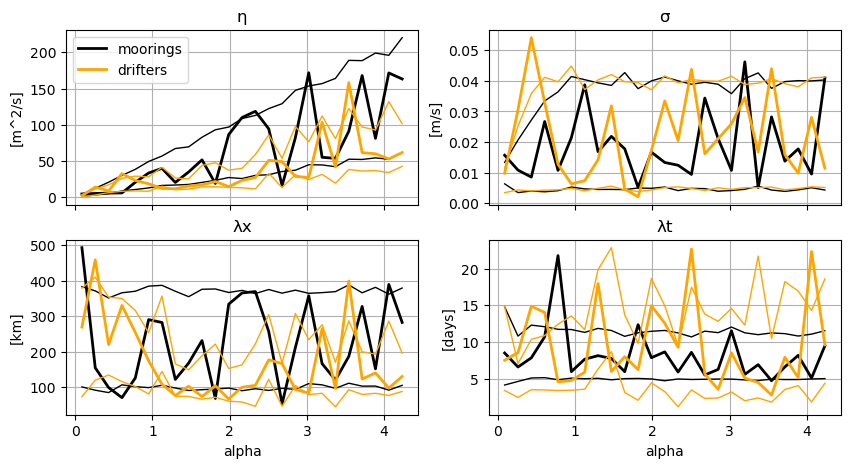

In [11]:
plot(mr=mr1,dr=dr1)

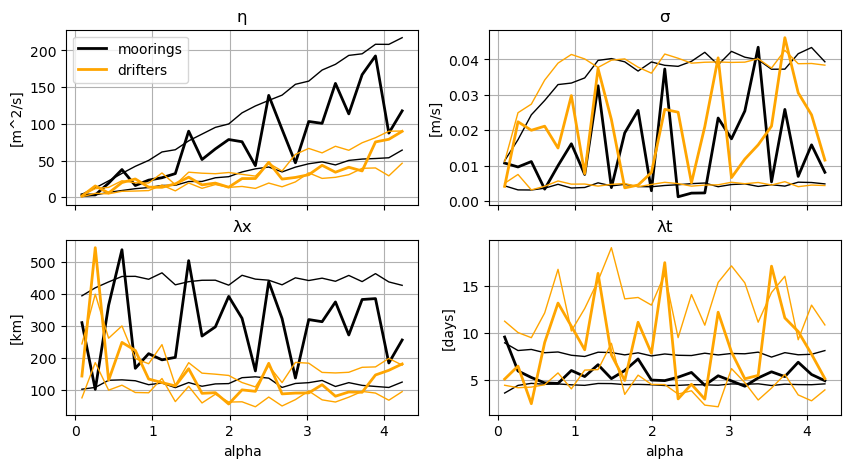

In [12]:
plot(mr=mr2,dr=dr2)

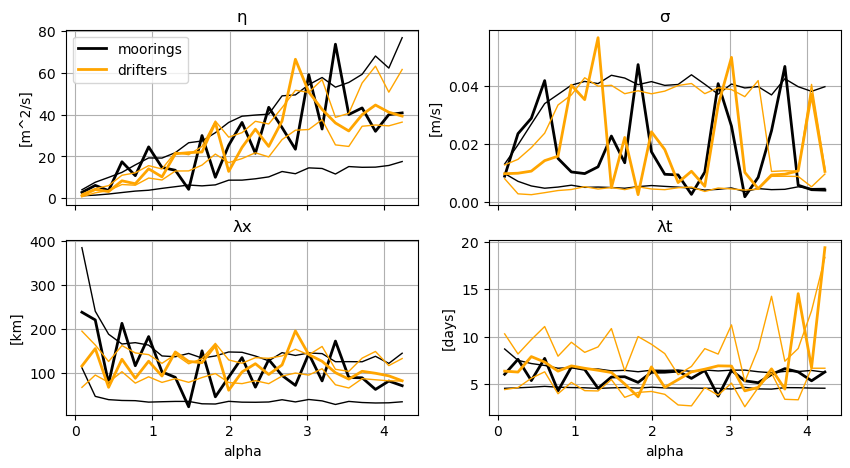

In [13]:
plot(mr=mr5,dr=dr5)
#plot(mr[Nxy],dr[Nxy])
#plot(mr[Nxy],None)
#plot(None,dr[Nxy])

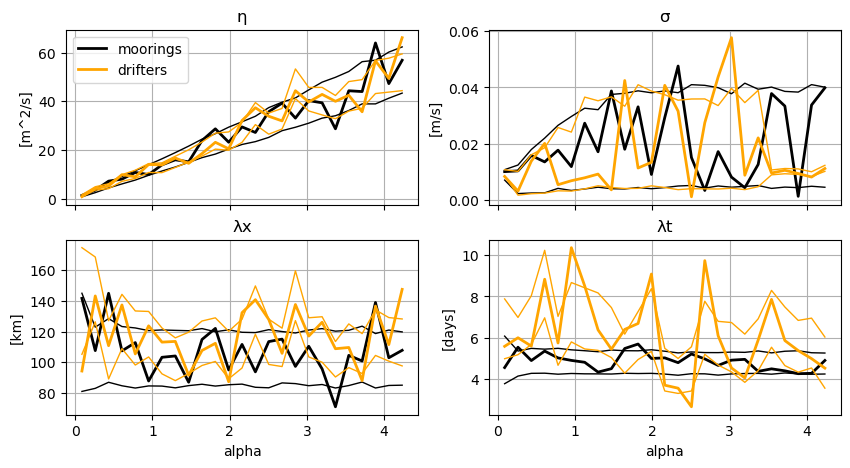

In [14]:
plot(mr=mr10,dr=dr10)

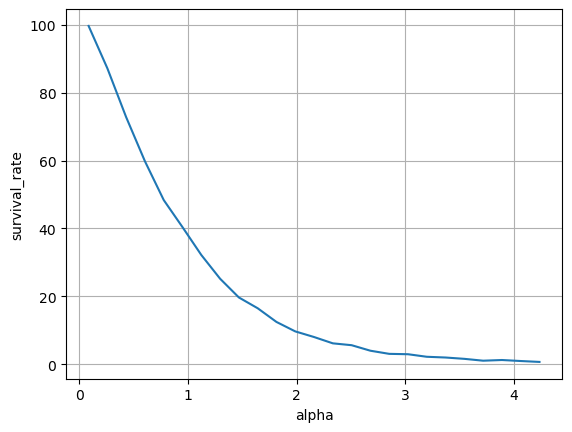

In [15]:
fig, ax = plt.subplots(1,1)
dr10["survival_rate"].plot()
ax.grid()

### plots

In [16]:
def plot_posterior_density(D):

    noise = D["noise"]
    covparams = D["covparams"]
        
    log_prob = D["log_prob"]
    priors_out = D["priors_out"]
    samples = D["samples"]
    
    #
    i = np.argmax(log_prob)
    MAP = samples[i, :]
    
    #
    priors_out_az = convert_to_az(priors_out, labels)
    samples_az    = convert_to_az(samples, labels)

    #
    axs = az.plot_density(   [samples_az[labels], 
                             priors_out_az[labels]],
                             shade=0.1,
                             grid=(1, 5),
                             textsize=12,
                             figsize=(12,3),
                             data_labels=('posterior','prior'),
                             hdi_prob=0.995)

    for t, m, ax in zip([noise,]+list(covparams), MAP, axs[0]):
        #print(t, ax)
        ax.axvline(t, color="k", ls="-")
        ax.axvline(m, color="b", ls="-")
        #ax.set_xlim(0, t*3)
        
def plot_posterior_corner(D):
    
    samples = D["samples"]    
    fig = corner.corner(samples, 
                        show_titles=True,
                        labels=labels,
                        plot_datapoints=True,
                        quantiles=[0.16, 0.5, 0.84])        

In [17]:
mr1["flow_scale"].to_pandas()

alpha
0.0864    0.1
0.2592    0.3
0.4320    0.5
0.6048    0.7
0.7776    0.9
0.9504    1.1
1.1232    1.3
1.2960    1.5
1.4688    1.7
1.6416    1.9
1.8144    2.1
1.9872    2.3
2.1600    2.5
2.3328    2.7
2.5056    2.9
2.6784    3.1
2.8512    3.3
3.0240    3.5
3.1968    3.7
3.3696    3.9
3.5424    4.1
3.7152    4.3
3.8880    4.5
4.0608    4.7
4.2336    4.9
dtype: float64

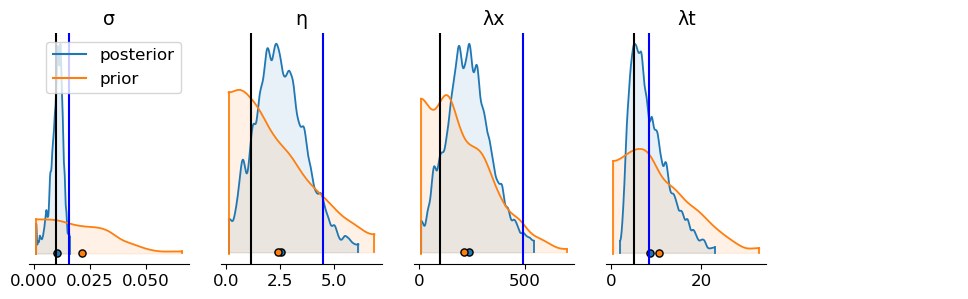

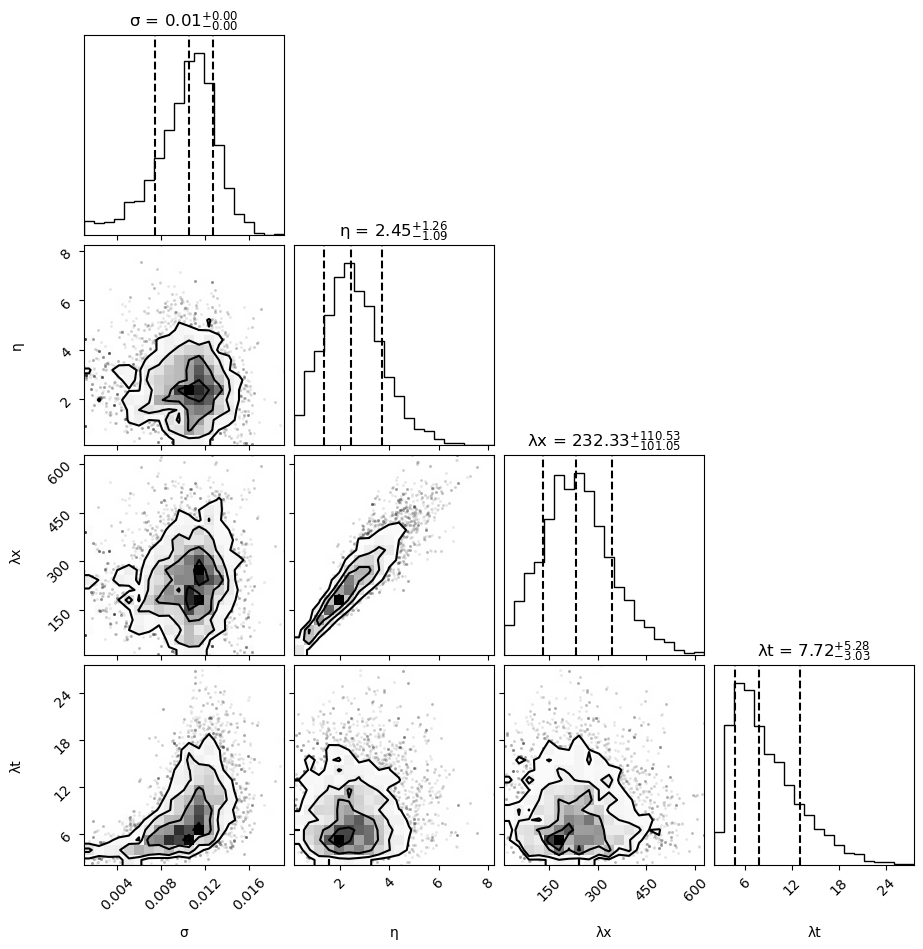

In [19]:
Nxy = 1
f = 0.1
#f = 4.9

Dm, Dr = load_inference(f, Nxy)

D = Dm    
plot_posterior_density(D)
plot_posterior_corner(D)

In [ ]:
for f in flow_scales:
    Dm, Dr = load_inference(f)
    plot_posterior_density(Dm)
    plot_posterior_density(Dr)
    plot_posterior_corner(Dm)
    plot_posterior_corner(Dr)

In [ ]:
# collect survival rates
S = dict()
for f in flow_scales:
    Dm, Dr = load_inference(f)
    S[f] = Dr["survival_rate"]
S

----

In [ ]:
cluster.close()